In [1]:
import pyemu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import flopy as fp
from flopy.utils.reference import SpatialReference
import os
import sys

sys.path.append("../../modules")
# hand made functions
from Rouss import *

flopy is installed in C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\flopy


In [2]:
ws = "workspace"
m_n_i = "pest_2d_r"
m_n = "pest_2D_R"

case = "2D_test"

In [3]:
sim = fp.mf6.MFSimulation.load(sim_ws=ws)
m = sim.get_model(m_n_i)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package obs...
    loading package npf...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
  loading ims package pest_2d_r...


In [4]:
sr = SpatialReference(delr=m.dis.delr.array, delc=m.dis.delc.array, xll=m.dis.xorigin.array, yll=m.dis.yorigin.array)
sr

xul:664525; yul:6207475; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0

In [5]:
# empty pst object
template_ws = "template"
pf = pyemu.prototypes.PstFrom(original_d=ws, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2020-06-30 09:24:58.356420 starting: opening PstFrom.log for logging
2020-06-30 09:24:58.356420 starting PstFrom process
2020-06-30 09:24:58.356420 starting: setting up dirs
2020-06-30 09:24:58.366463 starting: removing existing new_d 'template'
2020-06-30 09:24:59.406339 finished: removing existing new_d 'template' took: 0:00:01.039876
2020-06-30 09:24:59.406339 starting: copying original_d 'workspace' to new_d 'template'
2020-06-30 09:25:01.036618 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:01.630279
2020-06-30 09:25:01.046455 finished: setting up dirs took: 0:00:02.690035


In [7]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

2020-06-30 09:25:36.740830 starting: adding observations from tabular output file
2020-06-30 09:25:36.740830 starting: reading list template\heads.csv
2020-06-30 09:25:36.746378 finished: reading list template\heads.csv took: 0:00:00.005548
2020-06-30 09:25:36.756518 starting: building insfile for tabular output file heads.csv
2020-06-30 09:25:36.776448 finished: building insfile for tabular output file heads.csv took: 0:00:00.019930
2020-06-30 09:25:36.776448 starting: adding observation from instruction file 'template\heads.csv.ins'
2020-06-30 09:25:36.806374 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.029926
2020-06-30 09:25:36.806374 finished: adding observations from tabular output file took: 0:00:00.065544


In [8]:
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:0, nnz_obs:122


spatial variogram


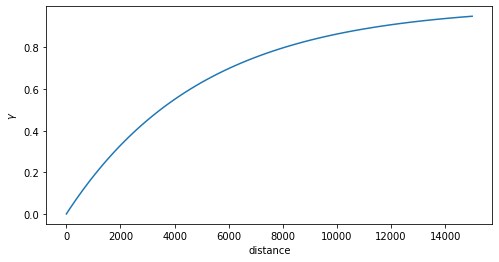

In [9]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=5000)
grid_gs = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs.plot()
print("spatial variogram")

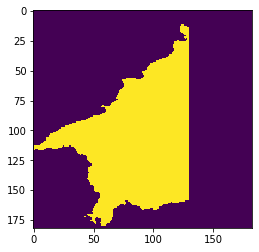

In [10]:
za = m.dis.idomain.array[0] # zone array for pp
za[:,130:]=0
plt.imshow(za)

In [11]:
pf.add_parameters(filenames="k.txt",par_type="pilotpoint",pp_space=10,zone_array=za,
                   par_name_base="kp",pargp="hp",
                   upper_bound=100,lower_bound=0.05,ult_ubound=1e-3,ult_lbound=5e-7,geostruct=grid_gs)

2020-06-30 09:25:53.456054 starting: adding pilotpoint type multiplier style parameters for file(s) ['k.txt']
2020-06-30 09:25:53.456054 starting: loading array template\k.txt
2020-06-30 09:25:53.586388 finished: loading array template\k.txt took: 0:00:00.130334
2020-06-30 09:25:53.586388 loaded array 'k.txt' of shape (182, 183)
2020-06-30 09:25:53.746248 starting: writing array-based template file 'kp_inst0_pilotpoint.csv.tpl'
2020-06-30 09:25:53.746248 starting: setting up pilot point parameters
2020-06-30 09:25:53.746248 No spatial reference (containing cell spacing) passed.
2020-06-30 09:25:53.746248 OK - using spatial reference in parent object.
2020-06-30 09:25:54.146042 95 pilot point parameters created
2020-06-30 09:25:54.146042 pilot point 'pargp':kp_inst:0
2020-06-30 09:25:54.146042 finished: setting up pilot point parameters took: 0:00:00.399794
2020-06-30 09:25:54.166474 starting: calculating factors for pargp=kp_inst:0
2020-06-30 09:25:54.176279 saving krige variance file:

In [12]:
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:95, nnz_obs:122


In [13]:
# add run model command
pf.mod_sys_cmds.append("..\..\..\exe\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:95, nnz_obs:122
2020-06-30 09:27:04.335135 forward_run line:pyemu.os_utils.run(r'..\..\..\exe\mf6')



In [14]:
#Rewrite ins file because Pyemu isn't smart enough
file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:95, nnz_obs:122
2020-06-30 09:27:04.994853 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\..\..\exe\mf6')
' already in sys cmds, skipping...
2020-06-30 09:27:05.014867 starting: building prior covariance matrix
2020-06-30 09:27:05.035192 saving prior covariance matrix to file template\2D_test.prior.cov
2020-06-30 09:27:05.075206 finished: building prior covariance matrix took: 0:00:00.060339


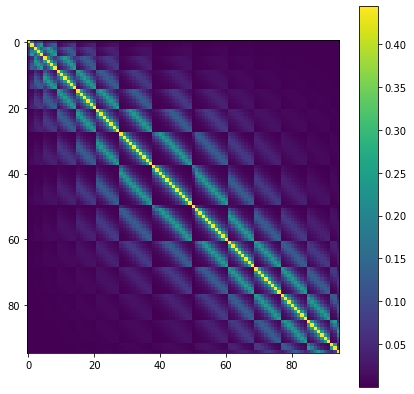

In [15]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)
plt.colorbar(g)

In [21]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:-1, npar_adj:95, nnz_obs:122


In [19]:
# pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd="template")

In [23]:
# LET'S FILL JACOBIAN WITH n WORKERS !
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=5,worker_root=".",master_dir=m_d)

Exception: pst_rel_path not found from worker_dir